<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#What-do-we-care-about-classifier-calibration?" data-toc-modified-id="What-do-we-care-about-classifier-calibration?-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>What do we care about classifier calibration?</a></span></li><li><span><a href="#Import-modules" data-toc-modified-id="Import-modules-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Import modules</a></span></li><li><span><a href="#Create-dataset" data-toc-modified-id="Create-dataset-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Create dataset</a></span></li><li><span><a href="#Plot-calibration-curve-for-Gaussian-Naive-Bayes" data-toc-modified-id="Plot-calibration-curve-for-Gaussian-Naive-Bayes-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Plot calibration curve for Gaussian Naive Bayes</a></span></li><li><span><a href="#Plot-calibration-curve-for-Linear-SVC" data-toc-modified-id="Plot-calibration-curve-for-Linear-SVC-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Plot calibration curve for Linear SVC</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Conclusions</a></span></li><li><span><a href="#References" data-toc-modified-id="References-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>References</a></span></li></ul></div>

# Introduction
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-warning">
<font color=black>

**What?** Comparison of calibration of classifier

</font>
</div>

# What do we care about classifier calibration?
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=black>

- The calibration module allows you to better calibrate the probabilities of a given model, or to add support for
probability prediction. 

</font>
</div>

# Import modules
<hr style = "border:2px solid black" ></hr>

In [1]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (brier_score_loss, precision_score, recall_score, f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import train_test_split

# Create dataset
<hr style = "border:2px solid black" ></hr>

In [2]:
# Create dataset of classification task with many redundant and few
# informative features
X, y = datasets.make_classification(n_samples=100000, n_features=20,
                                    n_informative=2, n_redundant=10,
                                    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.99,
                                                    random_state=42)



In [3]:
def plot_calibration_curve(est, name, fig_index):
    """Plot calibration curve for est w/o and with calibration. """
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')

    # Logistic regression with no calibration as baseline
    lr = LogisticRegression(C=1.)

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(lr, 'Logistic'),
                      (est, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
        print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
        print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()



# Plot calibration curve for Gaussian Naive Bayes
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=black>

- One can observe here that logistic regression is well calibrated while raw Gaussian naive Bayes performs very badly.
This is because of the redundant features which **VIOLATE** the assumption of feature-independence and result in
an overly confident classifier, which is indicated by the typical transposed-sigmoid curve. Brier score, the smaller
the better. 

- Calibration of the probabilities of Gaussian naive Bayes with isotonic regression can fix this issue as can be seen 
from the nearly diagonal calibration curve. Sigmoid calibration also improves the brier score slightly, albeit not 
as strongly as the non-parametric isotonic regression. This can be attributed to the fact that we have plenty of 
calibration data such that the greater flexibility of the non-parametric model can be exploited. 

</font>
</div>

Logistic:
	Brier: 0.099
	Precision: 0.872
	Recall: 0.851
	F1: 0.862

Naive Bayes:
	Brier: 0.118
	Precision: 0.857
	Recall: 0.876
	F1: 0.867

Naive Bayes + Isotonic:
	Brier: 0.098
	Precision: 0.883
	Recall: 0.836
	F1: 0.859

Naive Bayes + Sigmoid:
	Brier: 0.109
	Precision: 0.861
	Recall: 0.871
	F1: 0.866



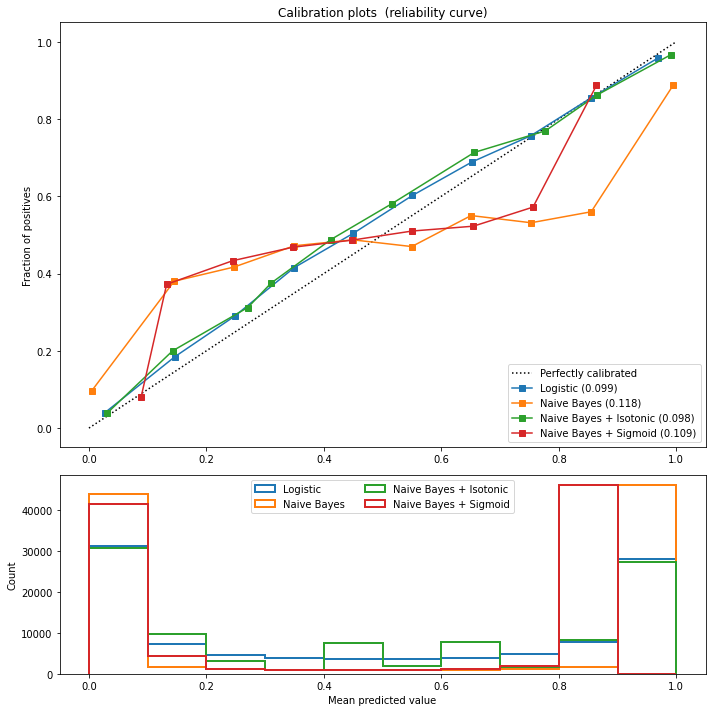

In [4]:
plot_calibration_curve(GaussianNB(), "Naive Bayes", 1)
plt.show()

# Plot calibration curve for Linear SVC
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=black>

- Both kinds of calibration can fix this issue and yield nearly identical results. 

</font>
</div>

Logistic:
	Brier: 0.099
	Precision: 0.872
	Recall: 0.851
	F1: 0.862

SVC:
	Brier: 0.163
	Precision: 0.872
	Recall: 0.852
	F1: 0.862

SVC + Isotonic:
	Brier: 0.100
	Precision: 0.853
	Recall: 0.878
	F1: 0.865

SVC + Sigmoid:
	Brier: 0.099
	Precision: 0.874
	Recall: 0.849
	F1: 0.861



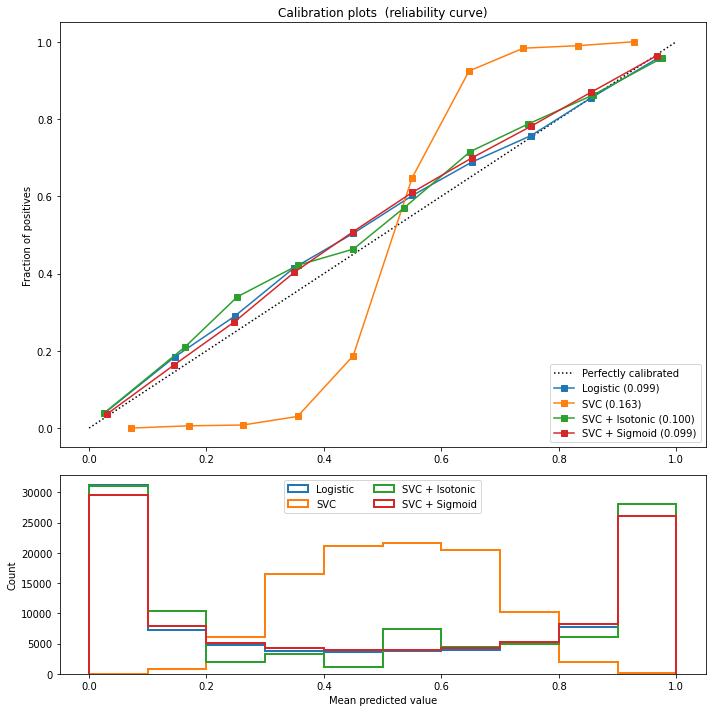

In [5]:
plot_calibration_curve(LinearSVC(max_iter=10000), "SVC", 2)
plt.show()

# Conclusions
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-danger">
<font color=black>

- This shows that sigmoid calibration can deal with situations where the calibration curve of the base classifier is sigmoid (e.g., for LinearSVC) but not where it is transposed-sigmoid (e.g., Gaussian naive Bayes).

</font>
</div>


# References
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-warning">
<font color=black>

- https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#sphx-glr-auto-examples-calibration-plot-calibration-curve-py
- https://scikit-learn.org/stable/modules/calibration.html

</font>
</div>